# Fox and Hounds '45 — Project Notebook

This notebook implements the **Fox and Hounds '45** project:

- Game engine & rules (6×6, dark-squares only, fox vs hounds)
- Baseline AIs: Fox_Random AI, Hounds_Random_AI
- Fox shortest path AI (A*)
- Hounds Minimax AI (depth ≥ 4 with alpha–beta)
- Simulation harness (100 games × 4 conditions)
- Plots/tables + reflections

In [3]:
# fix needed for matplotlib to run the game move by move
import matplotlib as mpl
mpl.rcParams['backend'] = 'inline'

import matplotlib.pyplot as plt
plt.close('all')

In [4]:
import random
import matplotlib
import pandas as pd
from dataclasses import dataclass, replace
from typing import List, Tuple, Optional


In [5]:
# configuration cell to start the pieces in the correct places
BOARD_N = 6
DARK = lambda r, c: (r + c) % 2 == 1

FOX_DELTAS   = [(-1,-1), (+1,+1), (+1,-1), (-1,+1)]
#this code here ensures that hounds do not go backwards, if you take a look at the board indices below,
# row is the first number and column is the second number, so we are only allowing positive row movements
# in this tuple, but hounds can still move side to side (-1, 1)
# there also is additional logic below to ensure the hounds don't move backwards
HOUND_DELTAS = [(+1,-1), (+1,+1)]

# Fox at the very top tip
FOX_START = (5, 0)
FOX_GOAL  = (0, 5)

# Hounds are at the three bottom dark places on the board one above bottom-right
HOUNDS_START = [(0, 3), (2, 5), (0, 5), (1, 4)]

In [7]:
from dataclasses import dataclass, replace
from typing import Tuple

@dataclass(frozen=True)
class State:
    """
    Represents the current game state.

    Attributes:
        fox (Tuple[int, int]): The (row, column) position of the fox on the board.
        hounds (Tuple[Tuple[int, int], ...]): The positions of all hounds as (row, column) pairs.
        to_move (str): Whose turn it is to move, either "fox" or "hounds".
        ply (int): The number of moves that have been played so far (starts at 0).
    """
    fox: Tuple[int, int]
    hounds: Tuple[Tuple[int, int], ...]
    to_move: str
    ply: int = 0  # Defaults to 0 at the start of the game


def initial_state() -> State:
    """
    Creates and returns the starting position of the game.

    Returns:
        State: A new game state where:
            - The fox starts at FOX_START.
            - The hounds start at their HOUNDS_START positions.
            - The fox moves first.
            - The ply counter is set to 0.
    """    
    return State(
        fox=FOX_START,
        hounds=tuple(sorted(HOUNDS_START)),
        to_move="fox",
        ply=0
    )



In [8]:
# board utility functions
def in_bounds(r: int, c: int) -> bool:
    """
    Checks if a given (row, column) position is inside the board.

    Args:
        r (int): The row index.
        c (int): The column index.

    Returns:
        bool: True if the position is within the board limits, False otherwise.
    """
    within_rows = 0 <= r < BOARD_N
    within_cols = 0 <= c < BOARD_N

    if within_rows and within_cols:
        return True
    else:
        return False



def is_empty(state: State, cell: Tuple[int, int]) -> bool:
    """
    Checks if a given cell on the board is empty.

    Args:
        state (State): The current game state, which includes the fox and hound positions.
        cell (Tuple[int, int]): The (row, column) position to check.

    Returns:
        bool: True if the cell has no fox or hound, False otherwise.
    """
    if state.fox == cell:
        return False  # fox is here
    return cell not in state.hounds  # any hound is here

def dark_neighbors(cell: Tuple[int, int], movement_deltas: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """
    Finds all valid dark-square neighbors that can be reached from a given cell.

    Args:
        cell (Tuple[int, int]): The current (row, column) position on the board.
        movement_deltas (List[Tuple[int, int]]): A list of possible movement directions, 
            where each tuple represents a row and column change (for example, (-1, -1) or (1, 1)).

    Returns:
        List[Tuple[int, int]]: A list of all valid neighboring cells that:
            - Are within the board boundaries.
            - Are on a dark square.
    """
    current_row, current_col = cell
    valid_neighbors: List[Tuple[int, int]] = []

    # Try each possible movement direction
    for row_offset, col_offset in movement_deltas:
        new_row = current_row + row_offset
        new_col = current_col + col_offset

        # Only keep this neighbor if it's on the board and on a dark square
        if in_bounds(new_row, new_col) and DARK(new_row, new_col):
            valid_neighbors.append((new_row, new_col))

    return valid_neighbors


In [9]:
# legal move generation
# Each move is represented as a tuple:
#   - Fox move:   ("FOX", from_position, to_position)
#   - Hound move: ("HOUND", hound_index, from_position, to_position)

def legal_moves_fox(game_state: State) -> List[Tuple]:
    """
    Finds all legal moves that the fox can make from its current position.

    Args:
        game_state (State): The current game state, which includes the fox and hound positions.

    Returns:
        List[Tuple]: A list of all possible fox moves. 
        Each move is represented as a tuple: ("FOX", current_position, target_position).

    Explanation:
        - The fox can move to any dark-square neighbor (from FOX_DELTAS).
        - A move is only valid if the target square is empty.
    """
    fox_moves: List[Tuple] = []

    # Look at each possible neighbor square the fox could move to
    for target_position in dark_neighbors(game_state.fox, FOX_DELTAS):
        if is_empty(game_state, target_position):
            fox_moves.append(("FOX", game_state.fox, target_position))

    return fox_moves

def is_forward_for_hound(start_cell: Tuple[int, int], target_cell: Tuple[int, int]) -> bool:
    """
    Enforces the 'no backward' rule for hounds.

    Board convention:
        - Row 0 is the top; rows increase as you go down.
        - 'Forward' for hounds means the row does NOT decrease.

    Args:
        start_cell  (row, col): The hound's current position.
        target_cell (row, col): Where the hound wants to move.

    Returns:
        bool: True if the move is not backward (target_row >= start_row), False otherwise.
    """
    start_row, start_col   = start_cell
    target_row, target_col = target_cell

    # Moving backward would reduce the row number
    moving_backward = target_row < start_row
    return not moving_backward

def legal_moves_hounds(game_state: State) -> List[Tuple]:
    """
    Finds all legal moves that the hounds can make from their current positions.

    Args:
        game_state (State): The current game state, which includes the fox and hound positions.

    Returns:
        List[Tuple]: A list of all possible hound moves. 
        Each move is represented as a tuple: 
        ("HOUND", hound_index, current_position, target_position).

    Explanation:
        - Each hound is checked one by one.
        - A hound can move to any dark-square neighbor (from HOUND_DELTAS).
        - A move is only valid if the target square is empty.
    """
    hound_moves: List[Tuple] = []

    # Go through each hound by index
    for hound_index, hound_position in enumerate(game_state.hounds):
        # Look at each possible neighbor square this hound could move to
        for target_position in dark_neighbors(hound_position, HOUND_DELTAS):
            #this is a double check to make sure hounds aren't moving backwards, although theoretically it's unnecessary
            if not is_forward_for_hound(hound_position, target_position):
                continue
            
            if is_empty(game_state, target_position):
                hound_moves.append(("HOUND", hound_index, hound_position, target_position))

    return hound_moves


In [10]:
# game state updates and end conditions

def apply_move(game_state: State, move: Tuple) -> State:
    """
    Updates the game state after applying a single move.

    Args:
        game_state (State): The current game state, which includes positions of the fox and hounds.
        move (Tuple): The move to apply. 
            - For the fox: ("FOX", from_position, to_position)
            - For a hound: ("HOUND", hound_index, from_position, to_position)

    Returns:
        State: A new game state that reflects the move made and switches the turn to the other side.

    Explanation:
        - If the fox moves, its position is updated, and it's now the hounds' turn.
        - If a hound moves, that hound's position is updated, and it's now the fox's turn.
        - The function uses `replace()` to create a new State (since State is frozen and cannot be edited directly).
        - The `ply` counter increases by 1 to track total moves.
    """
    if move[0] == "FOX":
        piece_type, from_position, to_position = move

        # Verify that the fox is actually located at the starting position of this move
        assert from_position == game_state.fox, "Fox move mismatch!"

        return replace(
            game_state,
            fox=to_position,
            to_move="hounds",
            ply=game_state.ply + 1
        )

    elif move[0] == "HOUND":
        piece_type, hound_index, from_position, to_position = move

        # Convert hounds tuple to a list so we can update one hound
        hounds_list = list(game_state.hounds)

        # Safety check: make sure the right hound is being moved
        assert hounds_list[hound_index] == from_position, "Hound move mismatch!"

        # Update this hound’s position
        hounds_list[hound_index] = to_position

        return replace(
            game_state,
            hounds=tuple(sorted(hounds_list)),  # sort so state stays consistent
            to_move="fox",
            ply=game_state.ply + 1
        )

    else:
        raise ValueError(f"Unknown piece type: {move[0]}")


def is_terminal(game_state: State) -> Tuple[bool, Optional[str]]:
    """
    Checks if the game has ended and determines the winner if there is one.

    Args:
        game_state (State): The current game state, which includes positions and whose turn it is.

    Returns:
        Tuple[bool, Optional[str]]: 
            - The first value is True if the game is over, False otherwise.
            - The second value is the winner ("fox" or "hounds") if the game has ended, or None if it hasn’t.

    Explanation:
        - The fox wins if it reaches the goal position (FOX_GOAL).
        - The hounds win if it's the fox's turn and the fox has no legal moves left.
        - If neither condition is met, the game continues.
    """
    # win condition 1, the fox has reached its goal position
    if game_state.fox == FOX_GOAL:
        return True, "fox"

    # win condition 2, it's the fox's turn, but it has no valid moves left
    if game_state.to_move == "fox" and not legal_moves_fox(game_state):
        return True, "hounds"

    # otherwise, the game continues
    return False, None

In [11]:
# Game Loop

def play_game(
    fox_policy,
    hounds_policy,
    max_half_moves: int = 200,
    verbose: bool = True
) -> Tuple[str, int]:
    """
    Runs the main game loop, alternating turns between the fox and hounds until someone wins or the move limit is reached.

    Args:
        fox_policy (function): A function (AI or player) that decides the fox's next move based on the current game state.
        hounds_policy (function): A function (AI or player) that decides the hounds' next move.
        max_half_moves (int, optional): The maximum number of half-moves (individual turns) before the game ends in a draw. Defaults to 200.
        verbose (bool, optional): If True, prints updates when the game ends. Defaults to True.

    Returns:
        Tuple[str, int]: 
            - The first value is the result: "fox", "hounds", or "draw".
            - The second value is the total number of half-moves played.

    Explanation:
        - The game starts from the initial setup.
        - On each turn, the current player (fox or hounds) uses their policy to choose a move.
        - If the fox reaches its goal or cannot move, the game ends.
        - If the hounds cannot move, they lose their turn (the fox moves next).
        - The game continues until a winner is found or the move limit is reached, resulting in a draw.
    """    
    # Start the game from the initial setup
    game_state = initial_state()

    for half_move in range(max_half_moves):
        # Check for the winning condition
        game_over, winner = is_terminal(game_state)
        if game_over:
            if verbose:
                print(f"Game Over! Winner: {winner} in {game_state.ply} half-moves.")
            return winner, game_state.ply

        # Decide which user (AI/player) moves next
        if game_state.to_move == "fox":
            chosen_move = fox_policy(game_state)
        else:
            chosen_move = hounds_policy(game_state)

        # Handle the case where the current player has no valid moves
        if chosen_move is None:
            if game_state.to_move == "fox":
                # If the fox can't move, the hounds win immediately
                return "hounds", game_state.ply
            else:
                # If the hounds can't move (very rare), they just lose their turn
                game_state = replace(
                    game_state,
                    to_move="fox",
                    ply=game_state.ply + 1
                )
                continue  # Skip to the next loop iteration

        # Apply the chosen move to update the game state
        game_state = apply_move(game_state, chosen_move)

    # If loop exits without a winner, declare a draw
    return "draw", game_state.ply


In [12]:
#random fox player
def Fox_Random_AI_Player(game_state: State):
    """
    Fox moves randomly in any direction
    """
    possible_moves = legal_moves_fox(game_state)
    return random.choice(possible_moves) if possible_moves else None


In [13]:
#random hound player
def Hounds_Random_AI_Player(game_state: State):
    """
    Hound moves randomly in any direction but backwards
    """
    possible_moves = legal_moves_hounds(game_state)
    return random.choice(possible_moves) if possible_moves else None

In [14]:
#actual fox AI player
def Fox_ShortestPath_AI_Player(game_state: State):
    """
    Chooses the fox's next move using an A* pathfinding algorithm.

    The fox tries to reach the goal square (FOX_GOAL) while avoiding hounds.
    It uses a heuristic based on Manhattan distance (distance in straight lines)
    and adds a "danger cost" if the fox moves too close to a hound.

    Args:
        game_state (State): The current game state, which includes the fox and hound positions.

    Returns:
        Tuple or None:
            - A move tuple in the form ("FOX", start_position, next_position) if a move is found.
            - None if no valid move exists.

    Explanation:
        - The algorithm uses A* search to find the shortest and safest path to the goal.
        - The cost of each step combines:
            1. The number of steps taken so far.
            2. The distance remaining to the goal (Manhattan distance).
            3. A small penalty for being near hounds.
        - If the fox can’t find a full path to the goal, it picks the first legal move available.
    """
    import heapq

    # using manhattan distance because we can only move in the four cardinal directions
    def manhattan(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    start = game_state.fox
    hounds = set(game_state.hounds)

    # create frontier to scan (decision cost, steps taken, fox position, path history)
    frontier = [(manhattan(start, FOX_GOAL), 0, start, [])]
    explored = set()

    # run while frontier is populated
    while frontier:
        cost, steps_taken, current_pos, path = heapq.heappop(frontier)

        if current_pos in explored:
            continue
        explored.add(current_pos)

        new_path = path + [current_pos]

        if current_pos == FOX_GOAL:
            if len(new_path) > 1:
                return ("FOX", start, new_path[1]) if len(new_path) > 1 else None

        for next_pos in dark_neighbors(current_pos, FOX_DELTAS):
            if not is_empty(game_state, next_pos) or next_pos in explored:
                continue

            steps_to_take = steps_taken + 1

            nearest_hound = min(manhattan(next_pos, hound) for hound in hounds)
            danger_cost = max(0, 2 - nearest_hound)

            total_cost = steps_to_take + manhattan(next_pos, FOX_GOAL) + danger_cost

            heapq.heappush(frontier, (total_cost, steps_to_take, next_pos, new_path))

    possible_moves = legal_moves_fox(game_state)
    return possible_moves[0] if possible_moves else None

In [15]:
#actualy hourd AI player
def evaluate_hounds(state: State) -> int:
    """
    Scores the current game state from the hounds' perspective.

    Higher scores mean the position is better for the hounds,
    and lower (negative) scores mean the fox is in a stronger position.

    Args:
        state (State): The current game state, including positions of the fox and hounds.

    Returns:
        int: A numerical score representing how good the position is for the hounds.

    Explanation:
        - If the fox reaches the goal, it's a huge loss for the hounds (-9999).
        - If the fox has no legal moves, it's a big win for the hounds (+9999).
        - Otherwise, the score is based on:
            1. Distance from the fox to the goal (further is better for hounds).
            2. Number of legal moves the fox has (fewer is better for hounds).
            3. Distance from the fox to the nearest hound (closer is better for hounds).
        - The values are weighted to emphasize trapping the fox and keeping it far from the goal.
    """
    if state.fox == FOX_GOAL:
        return -9999  # fox wins -> bad for hounds
    if state.to_move == "fox" and not legal_moves_fox(state):
        return +9999  # fox trapped -> good for hounds

    fox_row, fox_col = state.fox
    dist_to_goal = abs(fox_row - FOX_GOAL[0]) + abs(fox_col - FOX_GOAL[1])
    fox_moves = len(legal_moves_fox(state))
    nearest_hound = min(abs(fox_row - hr) + abs(fox_col - hc) for (hr, hc) in state.hounds)

    # Negate the fox-centric heuristic to favor hounds
    return (
        +3 * dist_to_goal   # further from goal is good for hounds
        -2 * fox_moves      # fewer fox moves is good for hounds
        +1 * nearest_hound  # fox closer to hounds is good
    )


def hounds_minimax(state, depth, alpha, beta, maximizing_player):
    """
    Uses the Minimax algorithm with alpha-beta pruning to find the best move for the hounds.

    Args:
        state (State): The current game state.
        depth (int): How many moves ahead the algorithm should look (search depth).
        alpha (float): The best value that the maximizer (hounds) can guarantee so far.
        beta (float): The best value that the minimizer (fox) can guarantee so far.
        maximizing_player (bool): True if it's the hounds' turn (they try to maximize the score),
                                  False if it's the fox's turn (it tries to minimize the score).

    Returns:
        int: A numerical score estimating how good the position is for the hounds.

    Explanation:
        - This function explores possible future moves up to a given depth.
        - When the hounds move, they try to **maximize** the evaluation score.
        - When the fox moves, it tries to **minimize** the evaluation score.
        - Alpha and beta are used to "cut off" branches that can't improve the result,
          which makes the search faster (alpha-beta pruning).
        - If the game is over or the depth limit is reached, the function returns
          the evaluation score for that position using `evaluate_hounds()`.
    """
    if is_terminal(state) or depth == 0:
        return evaluate_hounds(state)

    if maximizing_player:  # Hounds' turn (maximize)
        best = -float('inf')
        for move in legal_moves_hounds(state):
            value = hounds_minimax(apply_move(state, move), depth-1, alpha, beta, False)
            best = max(best, value)
            alpha = max(alpha, best)
            if beta <= alpha:
                break  # beta cutoff
        return best

    else:  # Fox's turn (minimize)
        best = float('inf')
        for move in legal_moves_fox(state):
            value = hounds_minimax(apply_move(state, move), depth-1, alpha, beta, True)
            best = min(best, value)
            beta = min(beta, best)
            if beta <= alpha:
                break  # alpha cutoff
        return best

def Hounds_Minimax_AI_Player(game_state: State):
    """
    Chooses the best move for the hounds using the Minimax algorithm with alpha-beta pruning.

    Args:
        game_state (State): The current game state, which includes all fox and hound positions.

    Returns:
        Tuple or None:
            - A move tuple in the form ("HOUND", hound_index, start_position, end_position)
              representing the best move found.
            - None if no valid move exists.

    Explanation:
        - The hounds look ahead a few moves (depth = 4) to predict how the fox might respond.
        - For each possible hound move:
            1. It applies the move to get a new game state.
            2. It calls `hounds_minimax()` to evaluate how good that move is.
        - The hound move with the highest score (best for the hounds) is selected.
        - If no good move is found, the function falls back to the first legal move.
    """
    best_score = -float('inf')
    best_move = None
    depth = 4

    for (_, hound_index, start, end) in legal_moves_hounds(game_state):
        new_state = apply_move(game_state, ("HOUND", hound_index, start, end))
        score = hounds_minimax(new_state, depth-1, -float('inf'), float('inf'), False)

        if score > best_score:  # maximize for hounds
            best_score = score
            best_move = ("HOUND", hound_index, start, end)

    if best_move:
        return best_move

    possible_moves = legal_moves_hounds(game_state)
    return possible_moves[0] if possible_moves else None


In [16]:
# Board Rendering and Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.transforms import Affine2D

# Colors and sizes
LIGHT_SQUARE_COLOR = "#ffffff"
DARK_SQUARE_COLOR  = "#7a7a7a"
GRID_LINE_COLOR    = "#8a8a8a"
FOX_COLOR          = "#e52420"
HOUND_COLOR        = "#1f59d1"
PIECE_RADIUS       = 0.28
GOAL_RING_RADIUS   = 0.18
GRID_LINE_WIDTH    = 0.8


def diamond_transform(ax):
    """
    Creates a rotation transformation that turns the board into a diamond shape.

    Args:
        ax (matplotlib.axes.Axes): The Matplotlib Axes object to apply the transformation to.

    Returns:
        Affine2D: A transformation that rotates the board 45 degrees around its center.

    Explanation:
        - Calculates the center point of the board using BOARD_N (the board size).
        - Creates an Affine2D transformation that rotates the board 45 degrees.
        - Combines the rotation with the axis’s existing data transformation.
        - This makes the board appear as a diamond instead of a square when drawn.
    """
    # Find the center of the board
    center_x = BOARD_N / 2
    center_y = BOARD_N / 2

    # Create a 45-degree rotation around the board center
    rotation = Affine2D().rotate_deg_around(center_x, center_y, 45)

    # Combine the rotation with the axis’s transformation
    return rotation + ax.transData


def board_position_to_xy(row: int, col: int, center: bool = False):
    """
    Converts a board position (row, column) into (x, y) coordinates for plotting.

    Args:
        row (int): The row index on the board.
        col (int): The column index on the board.
        center (bool, optional): If True, returns the center of the cell 
                                 instead of the top-left corner. Defaults to False.

    Returns:
        Tuple[float, float]: The (x, y) coordinates used for Matplotlib plotting.

    Explanation:
        - The y-axis is flipped so that the top of the board corresponds to smaller column values.
        - The x-axis matches the row index.
        - Adding 0.5 moves the point to the center of the cell (used when drawing pieces).
    """
    # Flip columns for proper vertical alignment
    y = (BOARD_N - 1 - col)

    # Set x to match the row index
    x = row

    # Shift by half a square to get the center point
    if center:
        return (x + 0.5, y + 0.5)
    else:
        return (x, y)


def make_diamond_board_ax(figsize=(6, 6), pad: float = 2.0, draw_frame: bool = False):
    """
    Creates and draws a rotated (diamond-shaped) game board using Matplotlib.

    Args:
        figsize (tuple, optional): The size of the Matplotlib figure. Defaults to (6, 6).
        pad (float, optional): Extra space around the edges of the board. Defaults to 2.0.
        draw_frame (bool, optional): If True, draws a border frame around the board. Defaults to False.

    Returns:
        Tuple[Figure, Axes, Transform]:
            - The Matplotlib figure and axes used for drawing.
            - The transformation applied to rotate the board (diamond layout).

    Explanation:
        - Sets up a square Matplotlib plot with no axes visible.
        - Rotates the board 45° using `diamond_transform()` to create a diamond look.
        - Draws alternating light and dark squares for the board.
        - Adds a circle marker to highlight the fox’s goal position.
        - Optionally draws a gray border frame around the entire board.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(-0.5 - pad, BOARD_N - 0.5 + pad)
    ax.set_ylim(-0.5 - pad, BOARD_N - 0.5 + pad)
    ax.set_aspect("equal")
    ax.axis("off")

    transform = diamond_transform(ax)

    # Draw all squares
    for row in range(BOARD_N):
        for col in range(BOARD_N):
            color = DARK_SQUARE_COLOR if (row + col) % 2 == 1 else LIGHT_SQUARE_COLOR
            x, y = board_position_to_xy(row, col)
            square = Rectangle(
                (x, y), 1, 1, facecolor=color,
                edgecolor=GRID_LINE_COLOR, linewidth=GRID_LINE_WIDTH
            )
            square.set_transform(transform)
            ax.add_patch(square)

    # Draw fox goal marker
    goal_x, goal_y = board_position_to_xy(*FOX_GOAL, center=True)
    goal_circle = Circle(
        (goal_x, goal_y), GOAL_RING_RADIUS,
        fill=False, edgecolor="#b20000", linewidth=1.6
    )
    goal_circle.set_transform(transform)
    ax.add_patch(goal_circle)

    # draw frame border
    if draw_frame:
        frame_x, frame_y = board_position_to_xy(0, 0)
        frame = Rectangle(
            (frame_x, frame_y), BOARD_N, BOARD_N,
            fill=False, edgecolor="#5a5a5a", linewidth=1.2
        )
        frame.set_transform(transform)
        ax.add_patch(frame)

    return fig, ax, transform


def create_piece_patches(game_state: State, transform):
    """
    Creates the visual pieces for the game board (the fox and hounds).

    This function turns the current game state into drawable circle shapes 
    that can be placed on the board using Matplotlib. It positions each 
    piece at the correct spot on the diamond board and applies the given 
    rotation transform so everything stays aligned visually.

    Args:
        game_state (State): The current game state with fox and hound positions.
        transform (Affine2D): The transformation that keeps the pieces rotated
                              correctly with the diamond-shaped board.

    Returns:
        List[Patch]: A list of circle patches representing the fox and all hounds.
    """
    patches = []

    # Fox piece
    fox_x, fox_y = board_position_to_xy(*game_state.fox, center=True)
    fox_patch = Circle(
        (fox_x, fox_y), PIECE_RADIUS,
        facecolor=FOX_COLOR, edgecolor="black", linewidth=1.1
    )
    fox_patch.set_transform(transform)
    patches.append(fox_patch)

    # Hound pieces
    for (hound_row, hound_col) in game_state.hounds:
        hound_x, hound_y = board_position_to_xy(hound_row, hound_col, center=True)
        hound_patch = Circle(
            (hound_x, hound_y), PIECE_RADIUS,
            facecolor=HOUND_COLOR, edgecolor="black", linewidth=1.0
        )
        hound_patch.set_transform(transform)
        patches.append(hound_patch)

    return patches


def render_game_state(board_axis, game_state: State, transform, previous_patches=None):
    """
    Updates the game board display to show the current positions of all pieces.

    This function clears any previously drawn pieces and redraws the fox and hounds 
    based on the latest game state. It helps keep the board visuals in sync with 
    the actual game logic.

    Args:
        board_axis (matplotlib.axes.Axes): The Matplotlib axis where the board is drawn.
        game_state (State): The current game state containing the positions of all pieces.
        transform (Affine2D): The rotation transform that keeps the pieces aligned with the diamond board.
        previous_patches (list, optional): A list of old piece patches to remove before redrawing. Defaults to None.

    Returns:
        List[Patch]: A list of the new patches (fox and hound pieces) currently displayed on the board.
    """
    # Remove previously drawn pieces (if any)
    if previous_patches:
        for patch in previous_patches:
            try:
                patch.remove()
            except:
                pass

    # Create and draw new piece patches
    patches = create_piece_patches(game_state, transform)
    for patch in patches:
        board_axis.add_patch(patch)

    return patches

def animate_game_with_board(
    fox_policy,
    hounds_policy,
    max_half_moves: int = 200,
    pause: float = 0.35,
    show_title: bool = True
    ):
    """
    Runs and visually animates a full game between the fox and hounds on a diamond-shaped board.

    This function shows each move step-by-step using Matplotlib, updating the board
    after every turn so the game can be watched as it plays out.

    Args:
        fox_policy (function): A function (AI or player) that decides the fox's next move.
        hounds_policy (function): A function (AI or player) that decides the hounds' next move.
        max_half_moves (int, optional): The maximum number of individual turns before the game ends in a draw. Defaults to 200.
        pause (float, optional): How long to pause (in seconds) between each move for the animation. Defaults to 0.35.
        show_title (bool, optional): Whether to display text above the board showing whose turn it is and the move count. Defaults to True.

    Returns:
        Tuple[Figure, Axes]:
            - The Matplotlib figure and axis that display the final game state.

    Explanation:
        - Sets up a diamond-shaped board with the fox and hounds in their starting positions.
        - Alternates between the fox and hound policies, applying moves to update the game state.
        - Redraws the pieces on the board after each move to create an animation effect.
        - Stops the animation when:
            1. The fox reaches the goal (fox wins).
            2. The fox has no legal moves (hounds win).
            3. The move limit is reached (draw).
    """
    board_figure, board_axis, transform = make_diamond_board_ax()
    game_state = initial_state()

    # Draw initial state
    patches = render_game_state(board_axis, game_state, transform, previous_patches=None)
    title = board_axis.set_title(
        f"to_move={game_state.to_move}  ply={game_state.ply}", pad=10
    ) if show_title else None
    plt.show(block=False)

    # Main game loop
    for half_move_count in range(max_half_moves):
        # Stop if the game is over
        game_over, winner = is_terminal(game_state)
        if game_over:
            if title:
                title.set_text(f"Winner: {winner} in {game_state.ply} plies")
            plt.pause(0.01)
            break

        # Decide which player moves
        chosen_move = (
            fox_policy(game_state) if game_state.to_move == "fox"
            else hounds_policy(game_state)
        )

        # Handle no-move situation
        if chosen_move is None:
            if game_state.to_move == "fox":
                if title:
                    title.set_text(f"Winner: hounds in {game_state.ply} plies")
                plt.pause(0.01)
                break
            else:
                game_state = replace(game_state, to_move="fox", ply=game_state.ply + 1)
        else:
            game_state = apply_move(game_state, chosen_move)

        # Redraw the board with the new state
        patches = render_game_state(board_axis, game_state, transform, previous_patches=patches)
        if title:
            title.set_text(f"to_move={game_state.to_move}  ply={game_state.ply}")
        plt.pause(pause)

    return board_figure, board_axis


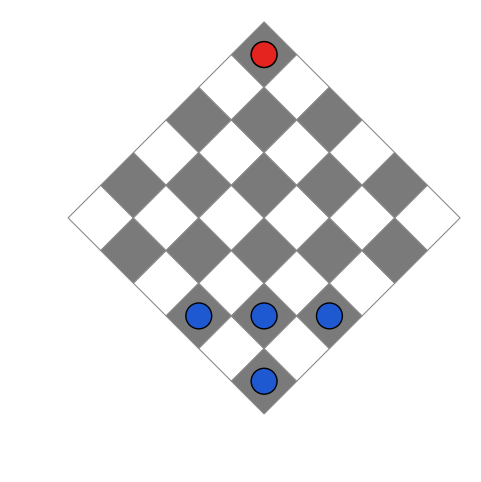

In [17]:
#render the game with the board and show it
board_figure, board_axis, transform = make_diamond_board_ax(figsize=(6,6), pad=2.0)
_ = render_game_state(board_axis, initial_state(), transform)
plt.show()

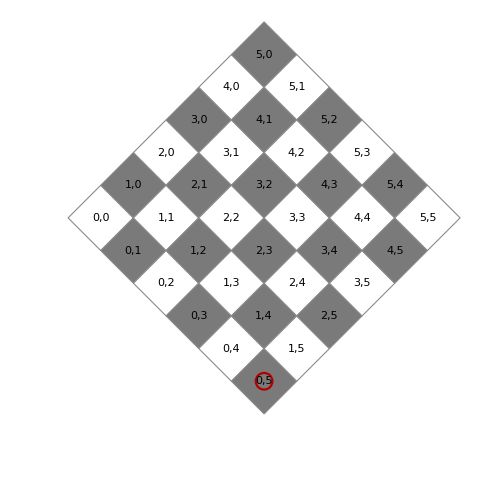

In [18]:
#show the indices so that we can put the fox's in the correct spots
def show_indices():
    fig, ax, t = make_diamond_board_ax(figsize=(6,6), pad=2.0)
    for r in range(BOARD_N):
        for c in range(BOARD_N):
            x, y = board_position_to_xy(r, c, center=True)
            txt = ax.text(x, y, f"{r},{c}", ha="center", va="center", fontsize=8)
            txt.set_transform(t)
    plt.show()

show_indices()

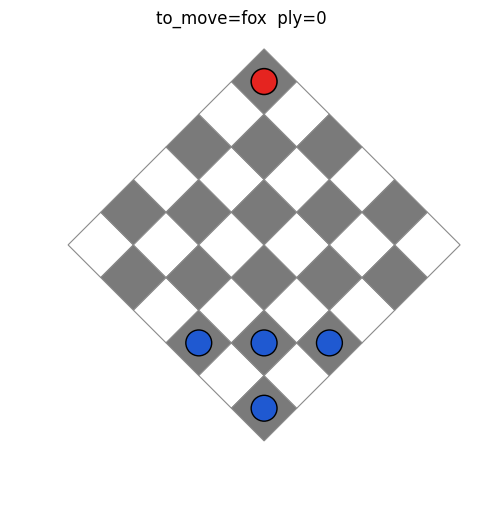

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Winner: hounds in 12 plies'}>)

In [19]:
animate_game_with_board(Fox_Random_AI_Player, Hounds_Random_AI_Player, pause=0.35)

In [20]:
# One move at a time visualizer
from dataclasses import replace
from typing import Callable, Optional, Tuple
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# A policy is just a function that takes a State and returns a move (tuple) or None
MovePolicyFn = Callable[[State], Optional[Tuple]]

def require_callable_policy(policy: MovePolicyFn, side_name: str) -> MovePolicyFn:
    """
    Checks that the given policy is a valid function.

    Args:
        policy (MovePolicyFn): Function that takes a State and returns a move or None.
        side_name (str): "fox" or "hounds" — used in the error message.

    Raises:
        ValueError: If the policy is not callable.
    """
    if not callable(policy):
        raise ValueError(
            f"{side_name} policy must be a function that accepts a State and returns "
            f"a move tuple or None. Got: {policy!r}"
        )
    return policy 


class GameAnimator:
    """
    Step-by-step visual game runner for debugging and demos.

    This class lets you advance the game one ply at a time and redraw the board
    after each step so you can see exactly what happened.

    Note:
        Unlike `animate_game_with_board(...)`, which runs the entire game in one go,
        `GameAnimator` is interactive/stepwise for debugging and visualization.
    """
    def __init__(self, fox_policy: MovePolicyFn, hounds_policy: MovePolicyFn):
        """
        Initialize the animator: validate policies, create the board, and draw the start position.

        Args:
            fox_policy (MovePolicyFn): Function that takes `State` and returns a fox move or None.
            hounds_policy (MovePolicyFn): Function that takes `State` and returns a hound move or None.
        """
        self.fox_policy_fn: MovePolicyFn = require_callable_policy(fox_policy, "fox")
        self.hounds_policy_fn: MovePolicyFn = require_callable_policy(hounds_policy, "hounds")

        # Create a fresh board and the initial game state
        self.board_figure, self.board_axis, self.transform = make_diamond_board_ax()
        self.game_state: State = initial_state()

        # Draw the initial pieces
        self.patches = render_game_state(
            board_axis=self.board_axis,
            game_state=self.game_state,
            transform=self.transform,
            previous_patches=None
        )
        self.title = None

        # Ensure the first frame becomes visible
        plt.show(block=False)
        plt.pause(0.01)

    def step(self, pause: float = 0.35) -> None:
        """
        Advance the animation by one ply (one side moves), then redraw.

        Behavior:
            - If the position is terminal, show winner text and stop.
            - Otherwise, call the active side's policy to get a move.
            - Handle “no move” cases per rules (fox: hounds win; hounds: skip turn).
            - Apply the move, redraw pieces, and pause briefly for visibility.

        Args:
            pause (float): Time in seconds to pause after redrawing (visual pacing).
        """
        game_over, winner = is_terminal(self.game_state)
        if game_over:
            if self.title is not None:
                self.title.set_text(f"Winner: {winner} in {self.game_state.ply} plies")
            self.refresh_inline()
            return

        # Pick the side to move and ask its policy for a move
        active_policy = self.fox_policy_fn if self.game_state.to_move == "fox" else self.hounds_policy_fn
        chosen_move = active_policy(self.game_state)

        # Handle “no legal move” cases per rules
        if chosen_move is None:
            if self.game_state.to_move == "fox":
                # Fox has no moves so the hounds win
                if self.title is not None:
                    self.title.set_text(f"Winner: hounds in {self.game_state.ply} plies")
                self.refresh_inline()
                return
            else:
                # Hounds have no move so we have to skip their turn
                self.game_state = replace(self.game_state, to_move="fox", ply=self.game_state.ply + 1)
        else:
            # Apply the chosen move to get the next state
            self.game_state = apply_move(self.game_state, chosen_move)

        # Redraw pieces for the new state
        self.patches = render_game_state(
            board_axis=self.board_axis,
            game_state=self.game_state,
            transform=self.transform,
            previous_patches=self.patches
        )
        if self.title is not None:
            self.title.set_text(f"to_move={self.game_state.to_move}  ply={self.game_state.ply}")

        # Make the update visible in the notebook
        self.refresh_inline()
        plt.pause(pause)

    def reset(self) -> State:
        """
        Reset the board to the initial state and redraw.

        Returns:
            State: The fresh starting game state.
        """
        self.game_state = initial_state()
        self.patches = render_game_state(
            board_axis=self.board_axis,
            game_state=self.game_state,
            transform=self.transform,
            previous_patches=self.patches
        )
        if self.title is not None:
            self.title.set_text(f"to_move={self.game_state.to_move}  ply={self.game_state.ply}")
        self.refresh_inline()
        plt.pause(0.01)
        return self.game_state

    def show_board(self) -> None:
        """
        Redraw the current board view without changing game state.
        """
        self.refresh_inline()

    def refresh_inline(self) -> None:
        """
        Internal helper: flush the Matplotlib canvas and re-display the figure in notebooks.

        Safe across backends: ignores errors if flush methods aren’t available.
        """
        try:
            self.board_axis.figure.canvas.draw_idle()
            self.board_axis.figure.canvas.flush_events()
        except Exception:
            pass  # some backends don't implement flush_events
        clear_output(wait=True)
        display(self.board_figure)



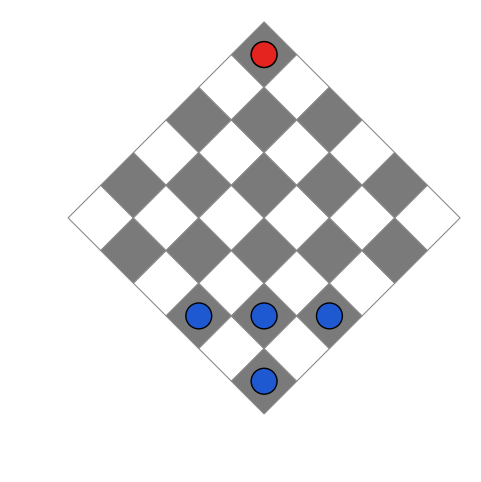

In [21]:
sess = GameAnimator(Fox_Random_AI_Player, Hounds_Random_AI_Player)

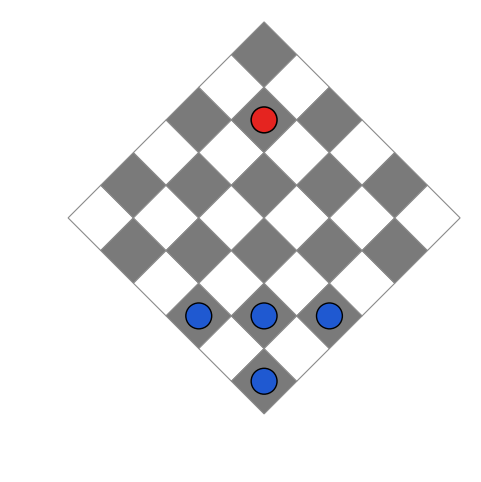

In [22]:
sess.step();
sess.show_board()   # advance one half-move and refresh

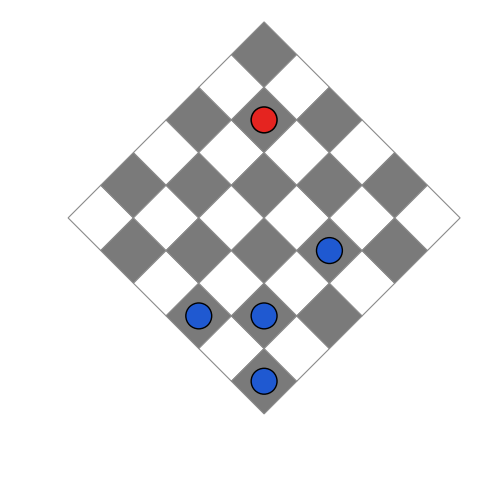

In [23]:
sess.step();
sess.show_board()   # advance one half-move and refresh

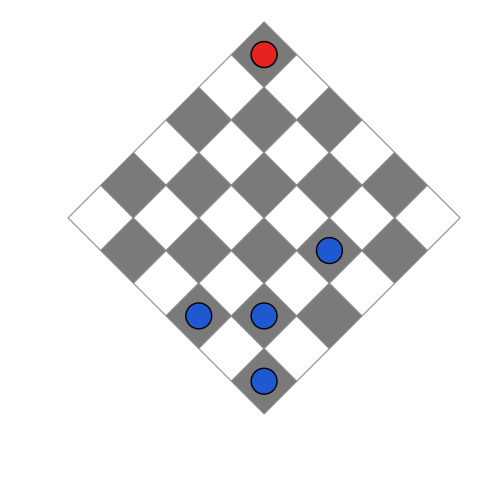

In [25]:
sess.step();
sess.show_board()

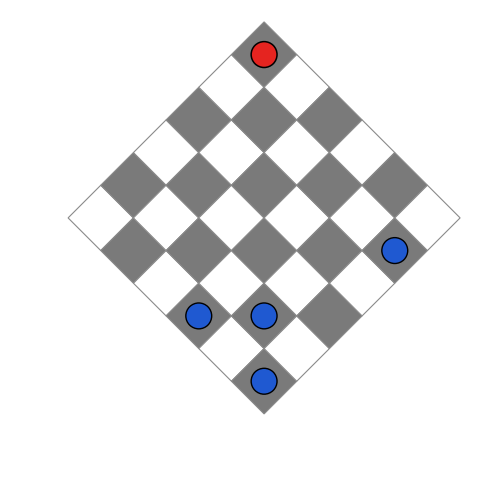

In [26]:
sess.step();
sess.show_board()

In [24]:
winner, total_number_of_moves = play_game(
    Fox_Random_AI_Player,
    Hounds_Random_AI_Player,
    max_half_moves=200,
    verbose=False
)

print("Winner:", winner, "| half-moves:", total_number_of_moves)



Winner: hounds | half-moves: 28


In [ ]:
# simulations

conditions = {
        "random_vs_random": (Fox_Random_AI_Player, Hounds_Random_AI_Player),
        "fox_ai_vs_random": (Fox_ShortestPath_AI_Player, Hounds_Random_AI_Player),
        "random_vs_hounds_ai": (Fox_Random_AI_Player, Hounds_Minimax_AI_Player),
        "fox_ai_vs_hounds_ai": (Fox_ShortestPath_AI_Player, Hounds_Minimax_AI_Player),
}

def run_simulation(
    conditions=conditions,
    n_games=100,
    max_half_moves=200,
    csv_file="results.csv",
    verbose=False
):
    """
    Runs many headless games across multiple policy matchups and summarizes results.

    Args:
        conditions (dict): Map condition name -> (fox_policy, hounds_policy).
        n_games (int): Games to run per condition.
        max_half_moves (int): Per-game half-move cap before declaring a draw.
        csv_file (str): Path to write per-game results as a CSV.
        verbose (bool): Unused here; kept for API symmetry.

    Returns:
        pandas.DataFrame: Summary with fox wins, hound wins, draws, and average half-moves by condition.
    """
    per_game_rows = []

    for cond_name, (fox_player, hounds_player) in conditions.items():
        for game_num in range(1, n_games + 1):
            winner, total_moves = play_game(
                fox_player,
                hounds_player,
                max_half_moves = max_half_moves,
                verbose=False
            )

            per_game_rows.append({
                "condition": cond_name,
                "game": game_num,
                "winner": winner,
                "half_moves": total_moves
            })

    # Save all games to CSV
    df = pd.DataFrame(per_game_rows)
    df.to_csv(csv_file, index=False)

    # Compute averages for notebook output
    summary = (
        df.groupby("condition")
          .agg(
              fox_wins=("winner", lambda x: (x == "fox").sum()),
              hound_wins=("winner", lambda x: (x == "hounds").sum()),
              draws=("winner", lambda x: (x == "draw").sum()),
              avg_half_moves=("half_moves", "mean"),
          )
          .reset_index()
    )

    return summary

In [ ]:
run_simulation()

,condition,fox_wins,hound_wins,draws,avg_half_moves
0,fox_ai_vs_hounds_ai,0,100,0,18.00
1,fox_ai_vs_random,96,4,0,29.28
2,random_vs_hounds_ai,19,79,2,31.49
3,random_vs_random,71,18,11,90.89
